## Visualisierung der Aktuellen Lagemeldungen Flensburg

Dieses Notebook lädt die Seite der Aktuellen Lagemeldungen der Stadt Flensburg und 
stellt die Daten grafisch da.

Da sich der Aufbau der Seite und der verwendeten Textbausteite jederzeit ändern kann, 
muss das Skipt dann angepasst werden

Hinweis: Infiziert wird aus Total - Genesen - Verstorben errechnet, anstelle die Zahl aus dem Fliesstext zu nehmen

Stand 06.02.2020

In [208]:
import re
import requests
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from io import StringIO
from html.parser import HTMLParser


In [209]:
CORONA_URL = 'https://www.flensburg.de/Aktuelles/Corona-Portal/Aktuelle-Lagemeldungen'

In [210]:
MATCHER_DATE = re.compile('<h2.{1,200}(\d{2}\.\d{2}\.2\d).{0,10}<.h2>')

MATCHER_POSITIVE_GESAMT = [re.compile(m, re.IGNORECASE) 
                           for m in ['Positive gesamt:.*?(\d{1,6})\D',
                                     '(\d{1,6}).{1,20}nachweislich Infizierte']]

MATCHER_GENESEN = [re.compile(m, re.IGNORECASE) 
                   for m in ['genesen:\D*(\d{1,6})\D',
                             '\s(\d{1,6})\D*genesen']]

MATCHER_VERSTORBEN = [re.compile(m, re.IGNORECASE) 
                      for m in ['verstorben:\D{1,10}(\d{1,6})\D', 
                                '(\d{1,6})\sVerstorben']]
 

In [211]:
def strip_tags(html):
    """remove all html tags. Via # https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python#925630"""
    
    class MLStripper(HTMLParser):
        def __init__(self):
            super().__init__()
            self.reset()
            self.strict = False
            self.convert_charrefs= True
            self.text = StringIO()
        def handle_data(self, d):
            self.text.write(d)
        def get_data(self):
            return self.text.getvalue()

    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [212]:
def split_page(page):
    """splits the page into date parts"""
    page_part = []
    date = None
    for line in page:
        if m := MATCHER_DATE.search(line):
            if date:
                yield date, '\n'.join(page_part)
            page_part = []
            date = m.group(1)
        else:
            page_part.append(line)
            
    if date and page_part:
        yield date, '\n'.join(page_part)


In [213]:
def parse_part(datestring, part):
    """parses a date part for match values"""
    search_part = strip_tags(part)
    positive_gesamt = None
    genesen = None
    verstorben = None
    for _matcher in MATCHER_POSITIVE_GESAMT:
        if m := _matcher.search(search_part):
            positive_gesamt = int(m.group(1))
            break
    for _matcher in MATCHER_GENESEN:
        if m := _matcher.search(search_part):
            genesen = int(m.group(1))
            break
    for _matcher in MATCHER_VERSTORBEN:
        if m := _matcher.search(search_part):
            verstorben = int(m.group(1))
            break
            
    return datetime.datetime.strptime(datestring, '%d.%m.%y'), positive_gesamt, genesen, verstorben
    
    

In [214]:
r = requests.get(CORONA_URL)
page = r.text.splitlines()

In [215]:
df = pd.DataFrame([parse_part(d, a) for d, a in split_page(page)]).dropna(subset=[1])

In [216]:
df.columns = 'Date', 'Total', 'Genesen', 'Verstorben'

In [217]:
df['Infiziert'] = df['Total'] - df['Genesen'] - df['Verstorben']

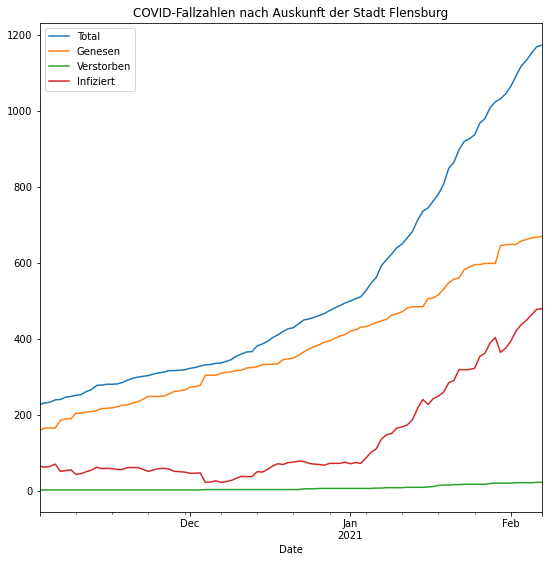

In [218]:
df[df.Date > '2020-11-01'].set_index('Date').resample('D').mean().plot(figsize=(9, 9), title='COVID-Fallzahlen nach Auskunft der Stadt Flensburg');

In [219]:
df[df.Date > '2020-11-11'].set_index('Date')

,Total,Genesen,Verstorben,Infiziert
Date,,,,
2021-02-07,1173.0,670.0,23.0,480.0
2021-02-06,1169.0,668.0,23.0,478.0
2021-02-05,1152.0,666.0,22.0,464.0
2021-02-04,1133.0,662.0,22.0,449.0
2021-02-03,1118.0,658.0,22.0,438.0
...,...,...,...,...
2020-11-16,281.0,219.0,3.0,59.0
2020-11-15,281.0,218.0,3.0,60.0
2020-11-14,279.0,217.0,3.0,59.0


In [220]:
df2 = df[df.Date > '2020-10-01'].set_index('Date').resample('D').mean()

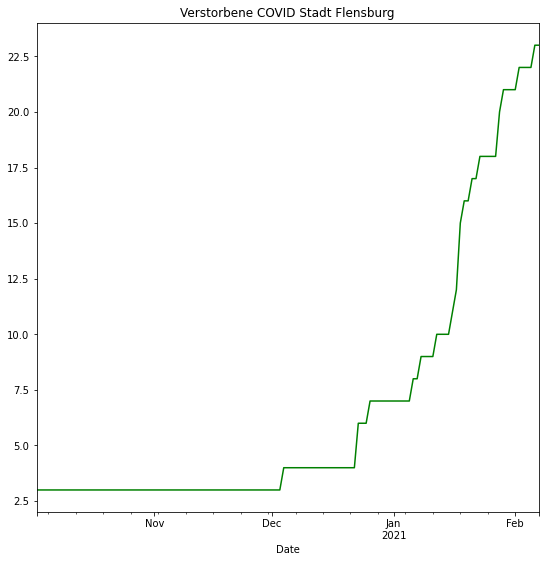

In [221]:
df2['Verstorben'].plot(figsize=(9, 9), color='green', title='Verstorbene COVID Stadt Flensburg');

In [222]:
# Vergleich der Werte mit den Werten von vor 7 Tagen
dft = df[df.Date > '2020-10-01'].set_index('Date').resample('D').mean()
dft2 = pd.concat([dft.copy(), dft.shift(7).copy()], axis= 1).copy().fillna(0)
dft2.columns = 'T1', 'G1', 'V1', 'I1','T2', 'G2', 'V2', 'I2'
dft2['Total'] = dft2['T1'] - dft2['T2']
dft2['Genesen'] = dft2['G1'] - dft2['G2']
dft2['Verstorben'] = dft2['V1'] - dft2['V2']
dft2['Infiziert'] = dft2['I1'] - dft2['I2']

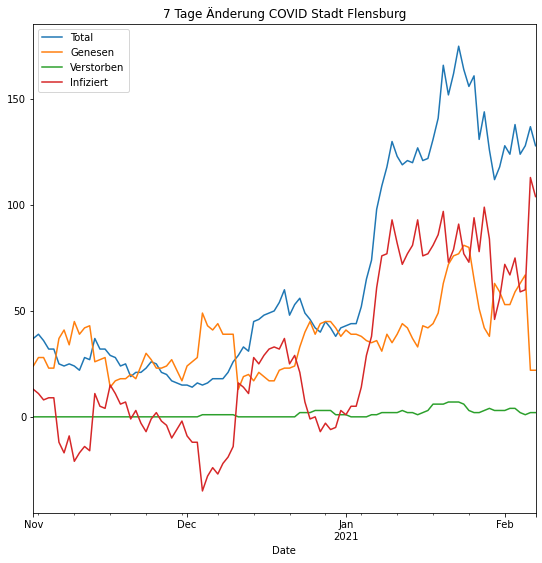

In [223]:
dft2[dft2.index >= '2020-11-01'][['Total','Genesen','Verstorben','Infiziert']].plot(figsize=(9, 9), title='7 Tage Änderung COVID Stadt Flensburg');

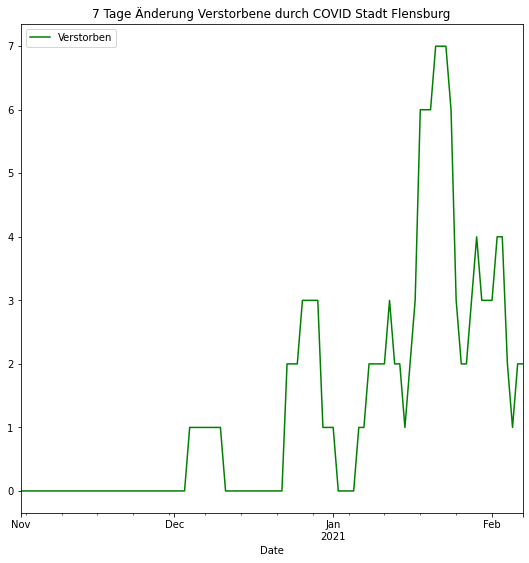

In [224]:
dft2[dft2.index >= '2020-11-01'][['Verstorben']].plot(figsize=(9, 9), color='green', title='7 Tage Änderung Verstorbene durch COVID Stadt Flensburg');

In [225]:
x = 8
(df.iloc[0+x].Total - df.iloc[7+x].Total) / 0.90164

124.21809147775166

In [226]:
df.iloc[8]

Date          2021-01-30 00:00:00
Total                        1032
Genesen                       646
Verstorben                     21
Infiziert                     365
Name: 8, dtype: object

In [207]:
from collections import defaultdict

In [47]:
d = defaultdict(list)